In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from sys import getsizeof
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import clear_output
from sklearn.ensemble import RandomForestClassifier
import os
import time
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns
path="/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/"
datapath="/its/home/drs25/Documents/data/Tactile Dataset/datasets/"
if os.name == 'nt':
    path="C:/Users/dexte/github/RoboSkin/Code/NewRigExperiments/"
    datapath="C:/Users/dexte/github/RoboSkin/Code/NewRigExperiments/texture-tactip/"
from IPython.display import clear_output
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:18230"
from sklearn.linear_model import Ridge, LinearRegression
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device=torch.device("cpu")
print(f"Using device: {device}")
from itertools import islice
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
def take(n, iterable):
    """Return the first n items of the iterable as a list."""
    return list(islice(iterable, n))

def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data, axis=0)
    return y


/its/home/drs25/miniconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Using device: cpu


## load data

In [2]:
class loaded:
    def __init__(self,t=20,filename="X_data_15.npz"):
        data = np.load(datapath+filename) #load data
        for array_name in data:
            self.X=(data[array_name].astype(np.uint8))
        data = np.load(datapath+filename.replace("X","y")) #load data
        for array_name in data:
            self.y=(data[array_name].astype(np.uint8))
        self.keys=['Leather', 'Cork', 'wool', 'LacedMatt', 'Gfoam', 'Plastic', 'Carpet', 'bubble', 'Efoam', 'cotton', 'LongCarpet', 'Flat', 'felt', 'Jeans', 'Ffoam']

        print("Dataset size:",self.X.shape[0],"\nWindow size:",self.X.shape[1],"\nImage:",self.X.shape[2:])
        print("Memory needed:",round(getsizeof(self.X)/ 1024 / 1024/ 1024,2),"GB")
        assert self.X.shape[0]==self.y.shape[0],"Incorrect data size match y="+str(self.y.shape[0])+" x="+str(self.X.shape[0])
        self.X=self.X[:,0:t]
        #randomize order
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
    def shuffle(self):
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
    def augment(self):
        #create rotations
        self.AugmentedX=np.zeros((len(self.X)*3,*self.X.shape[1:]),dtype=np.uint8)
        self.Augmentedy=np.zeros_like(np.concatenate((self.y,self.y,self.y)))
        for k,i in enumerate(range(0,len(self.AugmentedX),3)): #loop through the normal data and new data
            for j in range(len(self.X[0])):
                self.AugmentedX[i][j]=np.copy(self.X[k][j])
                self.AugmentedX[i+1][j]=cv2.resize(cv2.rotate(self.X[k][j].copy(), cv2.ROTATE_90_CLOCKWISE),(self.X[k][j].shape[1],self.X[k][j].shape[0]),interpolation=cv2.INTER_AREA)
                self.AugmentedX[i+2][j]=cv2.resize(cv2.rotate(self.X[k][j].copy(), cv2.ROTATE_180),(self.X[k][j].shape[1],self.X[k][j].shape[0]),interpolation=cv2.INTER_AREA)
                self.Augmentedy[i+1]=self.y[k]
                self.Augmentedy[i+2]=self.y[k]
                self.Augmentedy[i]=self.y[k]
                #self.AugmentedX[i+3][j]=cv2.rotate(self.X[k][j], cv2.ROTATE_90_COUNTERCLOCKWISE)
        print("Dataset size:",self.AugmentedX.shape[0],"\nWindow size:",self.X.shape[1],"\nImage:",self.X.shape[2:])
        print("Memory needed:",round(getsizeof(self.AugmentedX)/ 1024 / 1024/ 1024,2),"GB")
        self.X = self.AugmentedX
        self.y = self.Augmentedy
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
        del self.AugmentedX
        del self.Augmentedy
    def applySobel(self):
        for i in range(len(self.X)): #crop all images individually
            for j in range(len(self.X[0])):
                image=self.X[i][j]
                # Apply Sobel filter in x-direction
                sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # ksize=3 for a 3x3 Sobel kernel

                # Apply Sobel filter in y-direction
                sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

                # Convert the results back to uint8
                sobel_x = np.uint8(np.absolute(sobel_x))
                sobel_y = np.uint8(np.absolute(sobel_y))

                # Combine the results to get the final edge-detected image
                sobel_combined = cv2.bitwise_or(sobel_x, sobel_y)
                self.X[i][j]=sobel_combined

    def resize(self,percentage):
        h=int(self.X.shape[2]*percentage)
        w=int(self.X.shape[3]*percentage)
        new_array=np.zeros((*self.X.shape[0:2],h,w))

        for i in range(len(self.X)): #crop all images individually
            for j in range(len(self.X[0])):
                image=self.X[i][j]
                iamge = cv2.resize(image,(w,h),interpolation=cv2.INTER_AREA)
                new_array[i][j]=iamge
        self.X=new_array.copy()
#data=loaded(t=13)
#data.applySobel()
#data.augment()

data_ = np.load(datapath+"X_data_presstip.npz") #load data
X=None
for array_name in data_:
    X=data_[array_name]
X=(X* 3.3) / 65536 #convert to voltage
data_ = np.load(datapath+"y_data_presstip.npz") #load data
y=None
for array_name in data_:
    y=data_[array_name]
print(X.shape,y.shape)
cutoff_frequency = 3.3  # Define your cutoff frequency
sampling_rate = 50.0    # Define your sampling rate
filter_order = 5       # Order of the filter

# Assuming dataset is of shape (n, t, s)
def apply_filter_to_dataset(dataset, cutoff, fs, order=5):
    n, t, s = dataset.shape
    filtered_data = np.zeros_like(dataset)

    # Apply the filter to each sensor for each item
    for i in range(n):
        for j in range(s):
            filtered_data[i, :, j] = butter_lowpass_filter(dataset[i, :, j], cutoff, fs, order)

    return filtered_data

# Example usage
# dataset = np.random.randn(n, t, s)  # Example dataset (replace with your actual data)
filtered_dataset = apply_filter_to_dataset(X, cutoff_frequency, sampling_rate, filter_order)
#X=filtered_dataset


(3000, 20, 16) (3000,)


## electrical 

In [3]:
sensors=X[:,:,8:12]
trials=5
accuracy_test=np.zeros((len(range(2,16)),trials))
accuracy_train=np.zeros((len(range(2,16)),trials))

for i in range(2,16):
    for j in range(trials):
        #generate dataset
        classes=np.unique(y.copy())
        shuffled_classes = shuffle(classes)
        selected_classes = shuffled_classes[:i]
        mask = np.isin(y, selected_classes)
        X_filtered = sensors[mask].reshape(len(sensors[mask]),-1)
        y_filtered = y[mask]
        #train model
        print(np.unique(y_filtered),X_filtered.shape)
        train_X, test_X, train_y, test_y = train_test_split(X_filtered , y_filtered, test_size=0.2, random_state=42)
        clf = RandomForestClassifier(max_depth=25, random_state=0)
        clf.fit(train_X, train_y)
        y_pred = clf.predict(test_X)
        y_pred2 = clf.predict(train_X)

        loss=np.abs(y_pred-test_y)
        loss[loss>0]=1
        correct=len(loss)-np.sum(loss)
        print("Test Accuracy:",correct/len(loss))
        accuracy_test[i-2][j]=(correct/len(loss))
        loss=np.abs(y_pred2-train_y)
        loss[loss>0]=1
        correct=len(loss)-np.sum(loss)
        print("Train Accuracy:",correct/len(loss))
        accuracy_train[i-2][j]=(correct/len(loss))
        np.save(path+"/data/train_data_saize",accuracy_train)
        np.save(path+"/data/test_data_saize",accuracy_test)


[ 1 14] (400, 80)
Test Accuracy: 1.0
Train Accuracy: 1.0
[ 0 10] (400, 80)
Test Accuracy: 1.0
Train Accuracy: 1.0
[ 9 10] (400, 80)
Test Accuracy: 0.9875
Train Accuracy: 1.0
[ 7 13] (400, 80)
Test Accuracy: 0.9875
Train Accuracy: 1.0
[ 5 13] (400, 80)
Test Accuracy: 1.0
Train Accuracy: 1.0
[ 7 12 13] (600, 80)
Test Accuracy: 1.0
Train Accuracy: 1.0
[ 5 12 13] (600, 80)
Test Accuracy: 1.0
Train Accuracy: 1.0
[1 2 9] (600, 80)
Test Accuracy: 0.9333333333333333
Train Accuracy: 1.0
[ 4  9 12] (600, 80)
Test Accuracy: 1.0
Train Accuracy: 1.0
[3 6 7] (600, 80)
Test Accuracy: 0.9833333333333333
Train Accuracy: 1.0
[ 4  6  8 11] (800, 80)
Test Accuracy: 0.9625
Train Accuracy: 1.0
[3 5 8 9] (800, 80)
Test Accuracy: 0.9375
Train Accuracy: 1.0
[ 3 10 12 13] (800, 80)
Test Accuracy: 0.9625
Train Accuracy: 1.0
[ 4  6  9 11] (800, 80)
Test Accuracy: 0.9625
Train Accuracy: 1.0
[ 2  4 12 13] (800, 80)
Test Accuracy: 0.99375
Train Accuracy: 1.0
[ 4  5 10 11 14] (1000, 80)
Test Accuracy: 0.945
Train Acc

## optical

In [4]:
data=loaded(t=4)
data.applySobel()
#data.augment()

sensors=data.X
trials=5
accuracy_test=np.zeros((len(range(2,16)),trials))
accuracy_train=np.zeros((len(range(2,16)),trials))

for i in range(2,16):
    for j in range(trials):
        #generate dataset
        classes=np.unique(data.y.copy())
        shuffled_classes = shuffle(classes)
        selected_classes = shuffled_classes[:i]
        mask = np.isin(data.y, selected_classes)
        X_filtered = sensors[mask].reshape(len(sensors[mask]),-1)
        y_filtered = data.y[mask]
        #train model
        print(np.unique(y_filtered),X_filtered.shape)
        train_X, test_X, train_y, test_y = train_test_split(X_filtered , y_filtered, test_size=0.2, random_state=42)
        clf = RandomForestClassifier(max_depth=25, random_state=0)
        clf.fit(train_X, train_y)
        y_pred = clf.predict(test_X)
        y_pred2 = clf.predict(train_X)

        loss=np.abs(y_pred-test_y)
        loss[loss>0]=1
        correct=len(loss)-np.sum(loss)
        print("Test Accuracy:",correct/len(loss))
        accuracy_test[i-2][j]=(correct/len(loss))
        loss=np.abs(y_pred2-train_y)
        loss[loss>0]=1
        correct=len(loss)-np.sum(loss)
        print("Train Accuracy:",correct/len(loss))
        accuracy_train[i-2][j]=(correct/len(loss))
        np.save(path+"/data/train_data_saize_tt",accuracy_train)
        np.save(path+"/data/test_data_saize_tt",accuracy_test)


## show

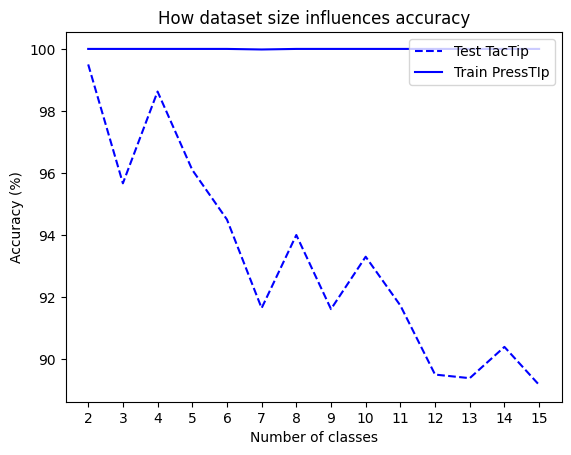

In [30]:
av_test=np.average(accuracy_test,axis=1)*100
av_train=np.average(accuracy_train,axis=1)*100
plt.plot(av_test,"--",c="b",label="Test TacTip")
plt.plot(av_train,c="b",label="Train PressTIp")
plt.title("How dataset size influences accuracy")
plt.ylabel("Accuracy (%)")
plt.xlabel("Number of classes")
plt.xticks([i for i in range(0,16-2)],[i for i in range(2,16)],)
plt.legend(loc="upper right")
plt.show()